In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style="whitegrid")

# Load the data
# Make sure 'dataset.csv' is in the same folder as your notebook
df = pd.read_csv('dataset.csv')

# Display the first few rows to understand the features
print("First 5 rows of the dataset:")
display(df.head())

# Check data shape (Target: ~114,000 rows, 21 columns)
print(f"\nDataset Shape: {df.shape}")

# Check data types and missing values
print("\nData Info:")
df.info()

First 5 rows of the dataset:


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic



Dataset Shape: (114000, 21)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 no

In [2]:
# 1. Drop non-predictive columns (Identifiers and Text)
# We keep 'track_genre' for now if you want to analyze it, 
# but for the main regression, we might focus on audio features.
cols_to_drop = ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name']

# Drop them if they exist
df_clean = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# 2. Remove duplicates
initial_rows = df_clean.shape[0]
df_clean = df_clean.drop_duplicates()
print(f"Removed {initial_rows - df_clean.shape[0]} duplicate rows.")

# 3. Check for Nulls
print("\nMissing Values per Column:")
print(df_clean.isnull().sum())

# (Optional) Drop rows with missing values if count is low
df_clean = df_clean.dropna()

print(f"\nFinal shape after cleaning: {df_clean.shape}")

Removed 7093 duplicate rows.

Missing Values per Column:
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

Final shape after cleaning: (106907, 16)


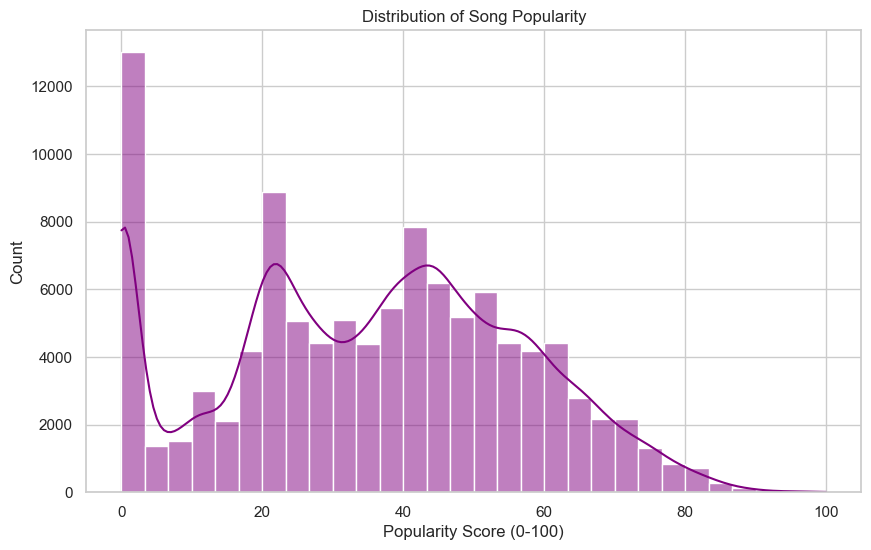

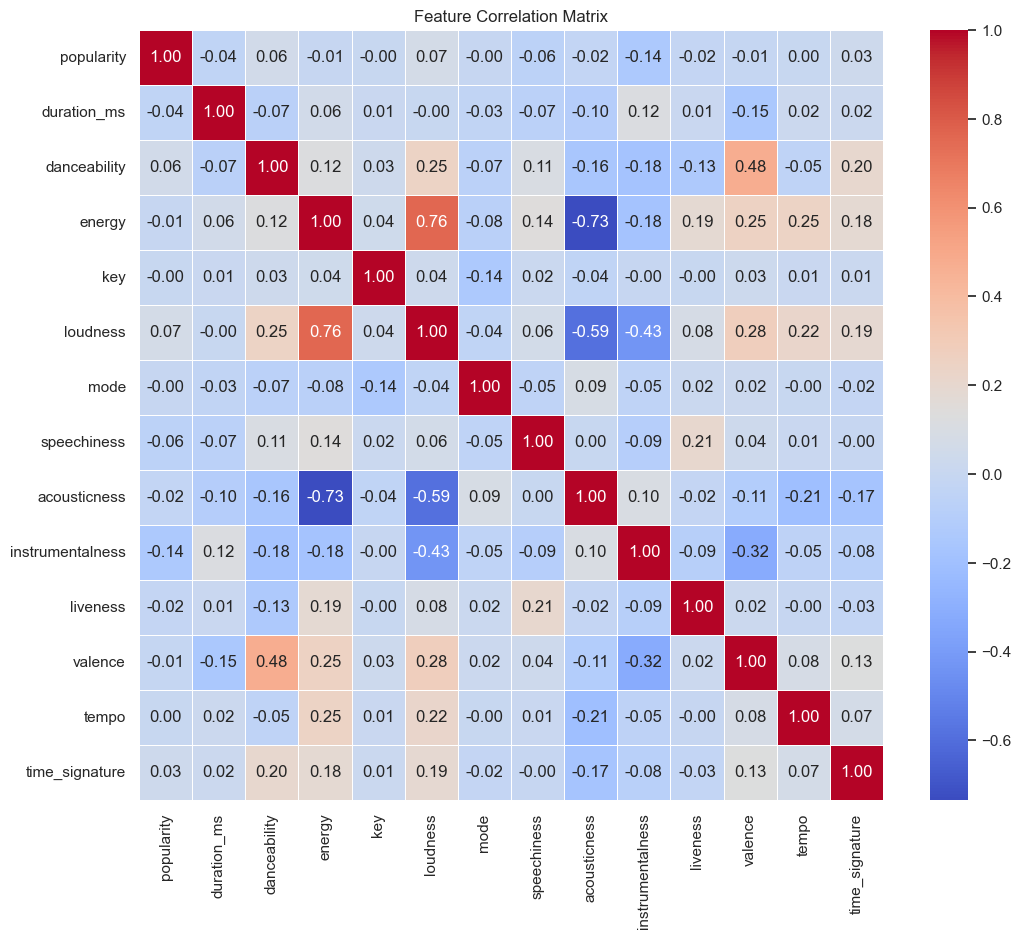

In [3]:
# 1. Distribution of the Target Variable (Popularity)
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['popularity'], kde=True, bins=30, color='purple')
plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity Score (0-100)')
plt.show()

# 2. Correlation Heatmap (Numerical Features Only)
plt.figure(figsize=(12, 10))
# Select only numeric columns for correlation
numeric_df = df_clean.select_dtypes(include=[np.number])
corr = numeric_df.corr()

# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

# 1. Feature Selection
# We will use the numeric audio features we analyzed in the heatmap
# We drop 'popularity' (target) and 'mode'/'key' (categorical-ish integers) for cleaner regression
feature_cols = ['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

X = df_clean[feature_cols]
y = df_clean['popularity']

# 2. Split the Data (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Standardization (Critical for Ridge!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Model 1: Ordinary Least Squares (OLS)
ols_model = LinearRegression()
ols_model.fit(X_train_scaled, y_train)
y_pred_ols = ols_model.predict(X_test_scaled)

# 5. Model 2: Ridge Regression
# alpha=1.0 is the default regularization strength. 
# You can experiment with this value (e.g., 0.1, 10, 100) later.
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

# 6. Evaluation Metrics
print("--- Model Performance ---")
print(f"OLS RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ols)):.4f}")
print(f"OLS R2 Score: {r2_score(y_test, y_pred_ols):.4f}")
print("-" * 25)
print(f"Ridge RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge)):.4f}")
print(f"Ridge R2 Score: {r2_score(y_test, y_pred_ridge):.4f}")

# 7. Coefficient Comparison (Optional but great for analysis)
# This shows how Ridge 'shrinks' the weights compared to OLS
coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'OLS_Coef': ols_model.coef_,
    'Ridge_Coef': ridge_model.coef_
})
print("\n--- Coefficient Comparison ---")
display(coef_df)

--- Model Performance ---
OLS RMSE: 21.0072
OLS R2 Score: 0.0369
-------------------------
Ridge RMSE: 21.0072
Ridge R2 Score: 0.0369

--- Coefficient Comparison ---


,Feature,OLS_Coef,Ridge_Coef
0,duration_ms,-0.758402,-0.758391
1,danceability,1.628504,1.628466
2,energy,-1.443664,-1.443610
3,loudness,1.172673,1.172649
4,speechiness,-1.639507,-1.639483
5,acousticness,-0.505627,-0.505602
6,instrumentalness,-3.240451,-3.240406
7,liveness,0.031094,0.031079
8,valence,-2.198006,-2.197950
9,tempo,0.199778,0.199768


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# --- Experiment 1: Tuning Ridge Regression ---
# We use GridSearchCV to test different 'alpha' values automatically.
# This satisfies the requirement for "identifying potential improvements."
print("--- Tuning Ridge Regression ---")
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge_cv = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)

print(f"Best Ridge Alpha: {ridge_cv.best_params_['alpha']}")
best_ridge = ridge_cv.best_estimator_
y_pred_ridge_tuned = best_ridge.predict(X_test_scaled)

print(f"Tuned Ridge RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge_tuned)):.4f}")
print(f"Tuned Ridge R2: {r2_score(y_test, y_pred_ridge_tuned):.4f}")


# --- Experiment 2: Random Forest Regressor ---
# Since Linear models performed poorly (R2 ~0.03), we try a non-linear model.
# Note: This might take a minute or two to run because the dataset is large.
print("\n--- Training Random Forest (Non-Linear Model) ---")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all CPU cores
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print(f"Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.4f}")
print(f"Random Forest R2: {r2_score(y_test, y_pred_rf):.4f}")

--- Tuning Ridge Regression ---
Best Ridge Alpha: 100.0
Tuned Ridge RMSE: 21.0072
Tuned Ridge R2: 0.0369

--- Training Random Forest (Non-Linear Model) ---
Random Forest RMSE: 15.7505
Random Forest R2: 0.4586


C:\Users\mabdu\AppData\Local\Temp\ipykernel_5908\836118973.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


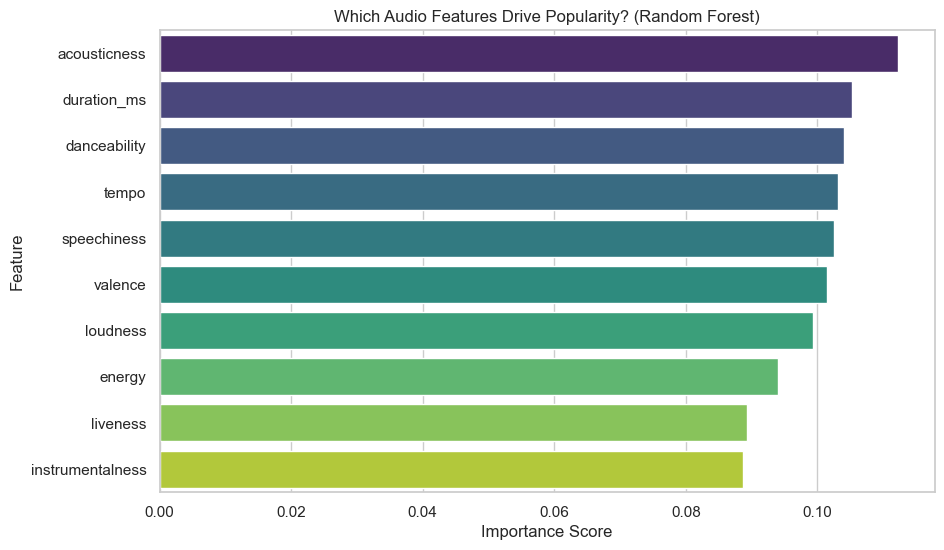

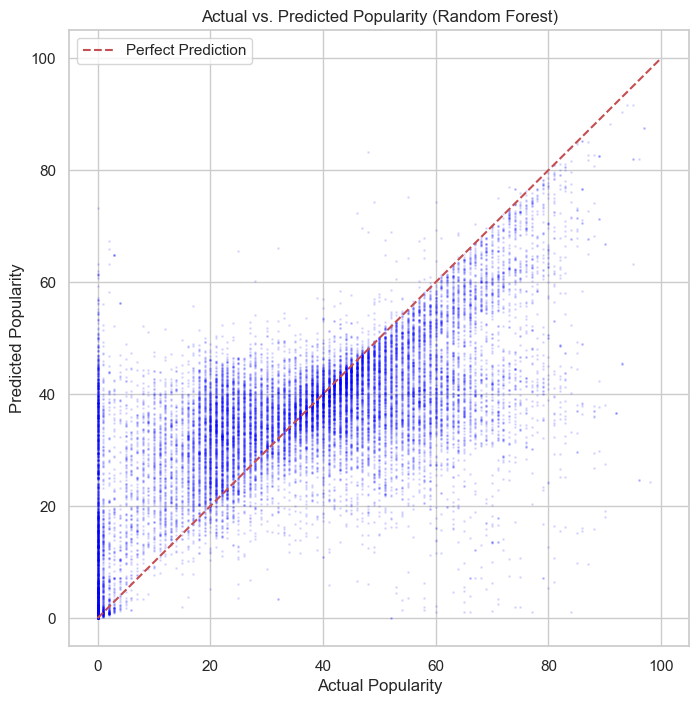

In [6]:
# Create a DataFrame for Feature Importance
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Which Audio Features Drive Popularity? (Random Forest)')
plt.xlabel('Importance Score')
plt.show()

# Visualizing Predictions vs Actuals (To show how well we fit)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_rf, alpha=0.1, color='blue', s=1)
plt.plot([0, 100], [0, 100], '--r', label='Perfect Prediction') # Identity line
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs. Predicted Popularity (Random Forest)')
plt.legend()
plt.show()